In [1]:
from ipyleaflet import Map, Marker,Polyline, FullScreenControl, WidgetControl, MarkerCluster, basemaps
from ipywidgets import IntSlider,jslink
import gpxpy
import geopy.distance as distance
import matplotlib.pyplot as pplot
from ipyfilechooser import FileChooser
from functools import reduce

Les cartes qu'on va utiliser

In [2]:
usedmap=basemaps.OpenStreetMap.Mapnik#valeur pas défaut
#usedmap=basemaps.OpenTopoMap
#usedmap=basemaps.HikeBike
#usedmap=basemaps.MtbMap

Le répertoire qui contient les fichiers .gpx :

In [3]:
default_dir="./"

On lit le fichier des positions gps:

In [4]:
fc = FileChooser(default_dir)
display(fc)

FileChooser(path='.', filename='', show_hidden='False')

In [5]:
gpx_file=open(fc.selected,'r')

On récupère les positions gps sous forme d'une liste de couples (latitude,longitude) :

In [6]:
gpx = gpxpy.parse(gpx_file)
points=gpx.tracks[0].segments[0].points

Il faut centrer la carte. Pour cela on calcule la moyenne des latitudes et des longitudes:

In [7]:
l=[(p.latitude,p.longitude) for p in points]
c=[sum(x) for x in zip(*l)]
center=(c[0]/len(l),c[1]/len(l))# le "centre" (la moyenne).

Et on dessine la carte, centrée en "center". Le facteur de zoom initial est un peu pifométrique: 

In [8]:
m = Map(basemap=usedmap,center=center, zoom=15)

On ajoute une petite tirette pour le zoom:

In [9]:
zoom_slider = IntSlider(description='Zoom:', min=12, max=30, value=15)
jslink((zoom_slider, 'value'), (m, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider, position='topright')
m.add_control(widget_control1)

In [10]:
display(m)

Map(center=[45.775022191214426, 4.864930919896639], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Bien. Maintenant on ajoute la trajectoire, qu'on a déja calculée. On ajoute aussi un bouton "Plein écran".

In [11]:
line = Polyline(
    locations=l,
    color="red" ,
    fill=False, weight=3
)
m.add_control(FullScreenControl())
m.add_layer(line)

Quelques calculs:

- Les distances entre les points successifs. C'est un service fourni par geopy (géodésiques sur l'ellipsoïde terrestre).
- La distance globale porcourue.
- Un "marker" tous les "delta" mêtres. 

In [12]:
delta=1000. # 1 km.

In [13]:
distance_parcourue=0.0
next = 0.0
marks=[]

for i,point in enumerate(points[1:]):
    new=(point.latitude,point.longitude)
    old=(points[i].latitude,points[i].longitude)
    d=distance.geodesic(new,old).m
    distance_parcourue += d
    if distance_parcourue >= next:
        next += delta
        marks.append(Marker(location=(point.latitude,point.longitude)))

In [14]:
print("Distance parcourue :",distance_parcourue)

Distance parcourue : 5370.6480983929105


Placer les marqueurs:

In [15]:
marker_cluster = MarkerCluster(
    markers=marks
)
m.add_layer(marker_cluster);

On redessine la carte :

In [16]:
print("zoomez pour voir les marqueurs");m

zoomez pour voir les marqueurs


Map(center=[45.775022191214426, 4.864930919896639], controls=(ZoomControl(options=['position', 'zoom_in_text',…

L'altitude au cours du parcours :

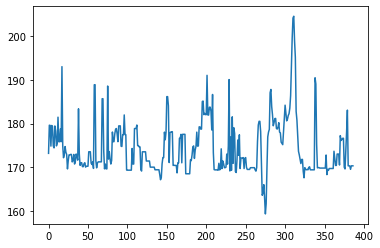

In [17]:
p=pplot.plot([point.elevation for point in points])

Cumul des montées et des descentes :

In [18]:
z=[x[1]-x[0] for x in zip([point.elevation for point in points][1:],[point.elevation for point in points][:-1])]
up= reduce(lambda a,b: a+max(b,0),z)
down= -reduce(lambda a,b: a+min(b,0),z)

Attention le gps n'est pas très précis pour les altitudes !

In [19]:
print("montée :",up,", descente :",down,"(mêtres).")

montée : 459.7500000000002 , descente : 463.32 (mêtres).
